# ПРИНЯТИЕ РЕШЕНИЙ В БИЗНЕСЕ

# Описание проекта

Необходимо проанализировать работу крупного интернет-магазина. Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки.
Необходимо:

1. Приоритизировать гипотезы
2. Запустить A/B-тест 
3. Проанализировать результаты

# Обзор и предобработка данных

Загрузим все библиотеки и посмотрим исходные таблицы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
import datetime as dt

import scipy.stats as stats
from scipy import stats as st

import warnings

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
hypothesis.info()
hypothesis.head()
hypothesis.isna().sum()
hypothesis.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


0

In [4]:
orders.info()
orders.head()
orders.isna().sum()
orders.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


0

In [5]:
visitors.info()
visitors.head()
visitors.isna().sum()
visitors.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


0

Меняем формат столбца date

In [6]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Меняем регистр

In [7]:
orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'}, inplace=True)


In [8]:
hypothesis.rename(columns={'Reach':'reach', 'Hypothesis':'hypothesis', 'Impact':'impact','Confidence':'confidence','Efforts':'efforts'}, inplace=True)

# ЧАСТЬ 1. ПРИОРИТИЗАЦИЯ ГИПОТЕЗ

Применим фреймворк ICE для приоритизации гипотез и отсортируем их по убыванию приоритета.

In [9]:
hypothesis['ICE'] = hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
hypothesis.sort_values(by='ICE',ascending=False).head()

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000


Теперь применим фреймворк RICE для приоритизации гипотез и также отсортируем их по убыванию приоритета.

In [10]:
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

hypothesis.sort_values(by='RICE',ascending=False).head()

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2


В обоих фреймворках учавствуют одни и те же гипотезы, отличается лишь их последовательность. Порядок отличается так как одна из них учитывает охват, а другая нет.

# ЧАСТЬ 2. АНАЛИЗ A/B-ТЕСТА

Проведен A/B-тест и получены результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

In [11]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [12]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Перед построением графиков необходимо для этого собрать необходимые данные

Создадим массив уникальных пар значений дат и групп теста методом, соберём агрегированные кумулятивные по дням данные о заказах. 

In [13]:
dates_grouped = orders[['date', 'group']].drop_duplicates()

orders_grouped = dates_grouped.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

orders_grouped.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина

In [14]:
visitors_grouped = dates_grouped.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max', 
            'group': 'max', 
            'visitors': 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_grouped.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим обе таблицы в одну с понятными названиями столбцов.

In [15]:
cumulative_data = orders_grouped.merge(
    visitors_grouped, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

Расчитаем конверсию

In [16]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


Теперь можно приступать к построениям графиков

# 1. Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения

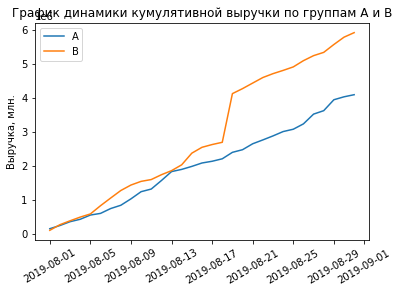

In [17]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.title('График динамики кумулятивной выручки по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xticks(rotation=30)
plt.legend()
plt.show() 

Выручка почти равномерно увеличивается в течение всего теста.
Однако график выручки группы В в одной точке резко возрос. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке.

# 2. Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.


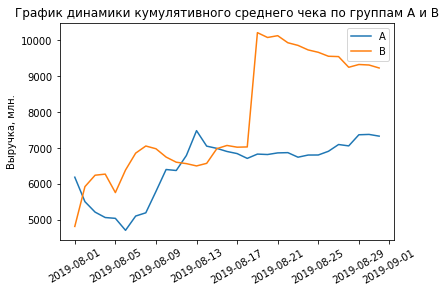

In [18]:
plt.plot(cumulative_revenue_a['date'], 
         cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'],
         label='A')

plt.plot(cumulative_revenue_b['date'], 
         cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], 
         label='B')

plt.title('График динамики кумулятивного среднего чека по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xticks(rotation=30)
plt.legend()
plt.show()

Средний чек тоже становится равномерным ближе к концу теста в группе А. А у группы B опять происходит резкий скачок. Возможно, в группу B во второй половине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

# 3. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

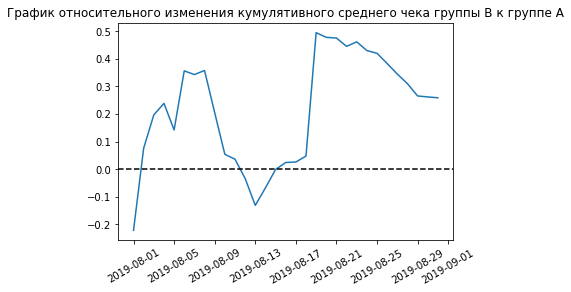

In [19]:
cumulative_revenue_ab = cumulative_revenue_a.merge(
    cumulative_revenue_b, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b']
)

plt.plot(cumulative_revenue_ab['date'], 
         (
             cumulative_revenue_ab['revenue_b']/cumulative_revenue_ab['orders_b']
         )/
         (
             cumulative_revenue_ab['revenue_a']/cumulative_revenue_ab['orders_a']
         )-1
        )
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=30)
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Где-то присутствуют крупные заказы и выбросы!

# 4. Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.

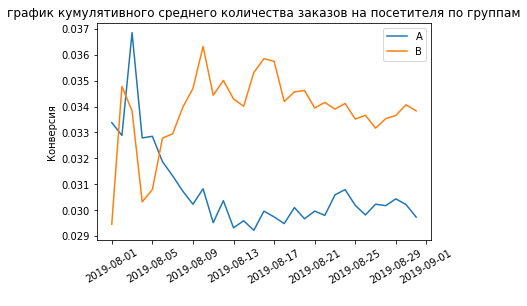

In [20]:
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.title('график кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel(' ')
plt.ylabel('Конверсия')
plt.xticks(rotation=30)
plt.show()

Сначала конверсии колебались, но довольно быстро выровнялись; результат группы В кажется более привлекательным.

# 5. Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения

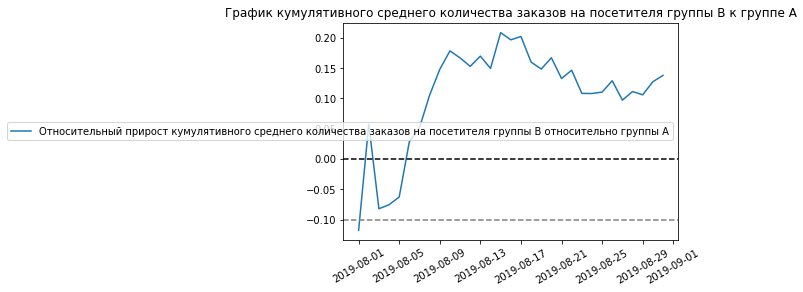

In [21]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1, label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя группы В к группе А')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xticks(rotation=30)
plt.show()

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Потом среднее количество заказов на посетителя для группы B снова уменьшалось, но теперь постепенно растёт.
В целом отношение среднего количества заказов на посетителя ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину. 

# 6.Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

In [22]:
orders_per_user = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})\
                         .rename(columns={'transaction_id':'orders'})


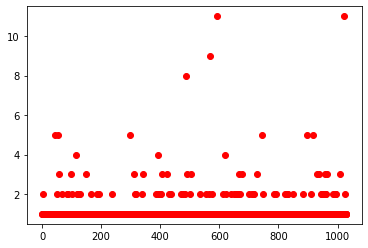

In [23]:
x_values = pd.Series(range(0,len(orders_per_user['orders'])))
plt.scatter(x_values, orders_per_user['orders'], color='red')
plt.show()

Большая часть пользователь с 2 и более заказами

# 7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей

In [24]:
np.percentile(orders_per_user['orders'], [ 95, 99])

array([2., 4.])

Границей для определения аномальных пользователей будет 4.

# 8. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

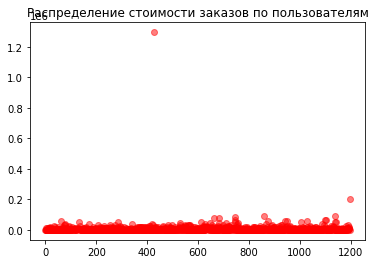

In [25]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], color='red', alpha=0.5)
plt.title('Распределение стоимости заказов по пользователям')
plt.show()

Есть аномальный выброс заказа более 1,2 млн.

# 9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [26]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Границу для определения аномальных заказов будем считать 58233

# 10. Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.

In [27]:
conversion = (orders.groupby('group').agg({'transaction_id':'count'}).rename(columns={'transaction_id':'orders'}))\
                                     .join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()
conversion['conversion'] = conversion['orders'] / conversion['visitors']

In [28]:
conversion

,group,orders,visitors,conversion
0,A,557,18736,0.029729
1,B,640,18916,0.033834


Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным — без удаления аномальных пользователей.

Введем основную и альтернативные гипотезы:
H0: Конверсия в группе A РАВНА конверсии в группе B
H1: Конверсия в группе A НЕ РАВНА конверсии в группе B

Уровень значимости: 0.05
Для проверки гипотез будем использовать непараметрический тест Уилкоксона-Манна-Уитни.

In [29]:
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_cummulative_a = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_a.columns = ['date', 'visitors_cummulative_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

visitors_cummulative_b = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_b.columns = ['date', 'visitors_cummulative_b']

orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_a.columns = ['date', 'orders_daily_a', 'revenue_per_date_a']

orders_cummulative_a = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_a.columns = ['date','orders_cummulative_a','revenue_cummulative_a']

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_b.columns = ['date', 'orders_daily_b', 'revenue_per_date_b']

orders_cummulative_b = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_b.columns = ['date','orders_cummulative_b','revenue_cummulative_b']


data = (
    orders_daily_a.merge(
        orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_b, left_on='date', right_on='date', how='left')
)

data.head()

,date,orders_daily_a,revenue_per_date_a,orders_daily_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Создадим переменные orders_per_user_a и orders_per_user_a в них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [30]:
orders_per_user_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_per_user_a.columns = ['visitor_id', 'orders']

orders_per_user_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_per_user_b.columns = ['visitor_id', 'orders']

Объявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [31]:
sample_a = pd.concat([orders_per_user_a['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitors_per_date_a'].sum() - 
                                          len(orders_per_user_a['orders'])), 
                          name='orders')],axis=0
                    )

sample_b = pd.concat([orders_per_user_b['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitors_per_date_b'].sum() - 
                                          len(orders_per_user_b['orders'])), 
                          name='orders')],axis=0
                    )

In [32]:
def stat_significance(data_a, data_b):
    alpha = 0.05
    p_value = stats.mannwhitneyu(data_a, data_b)[1]
    print("P-value: {0:.3f}".format(p_value))

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между группами есть разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    
    print("Относительный прирост В к А: {0:.3%}".format(data_b.mean() / data_a.mean()-1))

In [33]:
stat_significance(sample_a, sample_b)

P-value: 0.017
Отвергаем нулевую гипотезу: между группами есть разница
Относительный прирост В к А: 13.808%


 По неочищенным данным различия в конверсии между группами есть.

# 11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения



Воспользуемся критерием Манна-Уитни и введем основную и альтернативные гипотезы:
H0: Различий в среднем чеке между группами нет
H1: Различия в среднем чеке между группами есть

In [39]:
stat_significance(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])


P-value: 0.729
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: 25.871%


P-value значительно больше 0.05. Значит отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, причин нет. Средний чек группы B значительно выше среднего чека группы A.

# 12. Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения

Введем основную и альтернативную гипотезы:
H0: Конверсия в группе A РАВНА конверсии в группе B
H1: Конверсия в группе A НЕ РАВНА конверсии в группе B
Для начала очистим данные.

Примем за аномальных пользователей тех, кто совершил от 5 заказов или совершил заказ дороже 58233. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 4 — users_with_many_orders и пользователей, совершивших заказы дороже 58233 — users_with_expensive_orders. Объединим их в таблице abnormal_users.
Узнаем, сколько всего аномальных пользователей методом shape().

In [43]:
orders_per_user_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_per_user_a.columns = ['visitor_id', 'orders']

orders_per_user_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_per_user_b.columns = ['visitor_id', 'orders']

many_orders = np.percentile(orders_per_user['orders'], 99)
expensive_orders = np.percentile(orders['revenue'], 99)


users_with_many_orders = pd.concat(
    [
        orders_per_user_a[orders_per_user_a['orders'] > many_orders]['visitor_id'],
        orders_per_user_b[orders_per_user_b['orders'] > many_orders]['visitor_id'],
    ],
    axis=0,
)


users_with_expensive_orders = orders[orders['revenue'] > expensive_orders]['visitor_id']


abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormal_users.head(5))
abnormal_users.shape[0]

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64

15

Получилось 15 аномальных значений

In [44]:
sample_a_filtered = pd.concat(
    [
        orders_per_user_a[
            np.logical_not(orders_per_user_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_per_user_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_per_user_b[
            np.logical_not(orders_per_user_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_per_user_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [45]:

stat_significance(sample_a_filtered, sample_b_filtered)

P-value: 0.014
Отвергаем нулевую гипотезу: между группами есть разница
Относительный прирост В к А: 15.331%



B-конверсия снова превышает конверсию А со стат.значимостью.

# 13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения

Воспользуемся критерием Манна-Уитни и введем гипотезы:
H0: Средний чек A НЕ ПРЕВОСХОДИТ среднему чеку группы B
H1: Средний чек A ПРЕВОСХОДИТ среднему чеку группы B

In [46]:
stat_significance(
    orders[(orders['group']=='A') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue'], 
    orders[(orders['group']=='B') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue']
                  )

P-value: 0.851
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: -0.575%


Не получилось отвергнуть нулевую гипотезу, по разнице средних чеков групп различий практически нет.

# Выводы

Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
По сырым данным нет статистически значимого различия по среднему чеку между группами. Однако после удаления аномалий статистически значимое различие есть.
График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.

Можно остановить тест, зафиксировав победу группы B (ее конверсия значительно выше конверсии группы А).